In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from visualization_toolkit.adapters.mse_noise import mse_noise_experiment
from visualization_toolkit.plots.mse import mseplot

### Utils

In [3]:
def generate_clean_signals(
    n_signals: int,
    n_samples: int,
    fs: float = 1.0,
):
    t = np.arange(n_samples) / fs
    signals = []

    for _ in range(n_signals):
        x = np.sin(2 * np.pi * 0.05 * t) + 0.5 * np.sin(2 * np.pi * 0.12 * t)
        signals.append(x)

    return np.array(signals)


def add_noise(signal: np.ndarray, ratio: float) -> np.ndarray:
    """
    Adds noise with a specified ratio of signal to noise ratio (sigma_signal / sigma_noise).

    Parameters:
        signal: The original signal.
        ratio: The desired sigma_signal / sigma_noise ratio (for example, 10 = noise 10 times weaker).

    Returns:
        A noisy signal, noise.
    """
    sigma_signal = np.std(signal, ddof=1)
    sigma_noise = sigma_signal / ratio

    noise = np.random.normal(0, sigma_noise, size=signal.shape)

    return signal + noise, noise


def generate_noisy_dataset(
    clean_signals,
    noise_ratios,
):
    original = []
    noisy = []

    for ratio in noise_ratios:
        for signal in clean_signals:
            original.append(signal)
            noisy_signal, _ = add_noise(signal, ratio)
            noisy.append(noisy_signal)

    return np.array(original), np.array(noisy)


def moving_average(x, k):
    return np.convolve(x, np.ones(k) / k, mode="same")

### Usage example

In [4]:
noise_ratios = np.arange(0.1, 2.5, 0.5)
snr_array = 20 * np.log10(noise_ratios)
n_realizations = 20
n_samples = 512
print(noise_ratios, snr_array)

[0.1 0.6 1.1 1.6 2.1] [-20.          -4.43697499   0.8278537    4.08239965   6.44438589]


In [5]:
clean = generate_clean_signals(
    n_realizations,
    n_samples,
)

original_signals, noisy_signals = generate_noisy_dataset(
    clean,
    noise_ratios,
)

In [6]:
signals = {
    "N": noisy_signals,
    "MA-5": np.array([moving_average(x, 5) for x in noisy_signals]),
    "MA-2": np.array([moving_average(x, 2) for x in noisy_signals]),
}

In [7]:
mse_df = mse_noise_experiment(original_signals, signals, noise_ratios)

In [8]:
mse_df.head(5)

,snr,mse,label,run
0,-20.0,63.876082,N,0
1,-20.0,61.273482,N,1
2,-20.0,65.712498,N,2
3,-20.0,54.835842,N,3
4,-20.0,64.706914,N,4


In [9]:
# You can add your styles for graphs using styles parameter
print(mse_df["label"].unique())
styles = {
    "N": dict(marker="*", markersize=12, markerfacecolor="none", color="k"),
    "MA-2": dict(
        marker="d", markersize=12, markerfacecolor="none", linestyle="-.", color="k"
    ),
    "MA-5": dict(
        marker="o", markersize=12, markerfacecolor="none", linestyle="--", color="k"
    ),
}

['N' 'MA-5' 'MA-2']


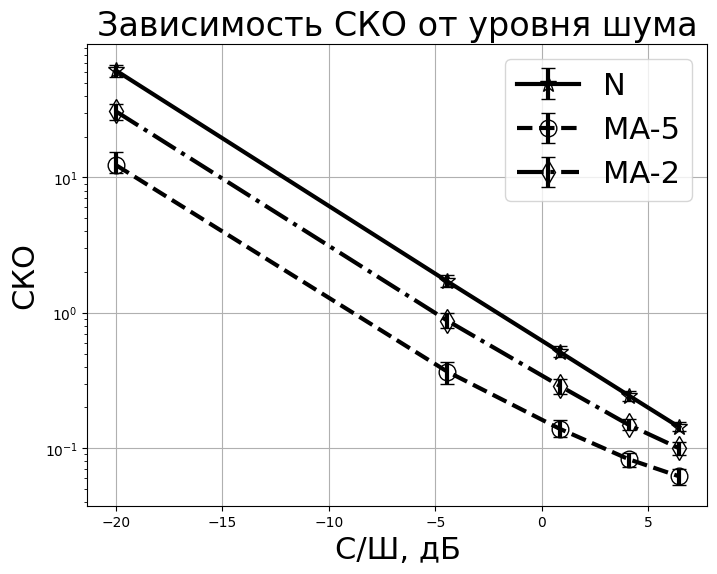

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
mseplot(data=mse_df, x="snr", y="mse", hue="label", styles=styles, ax=ax)
plt.show()